# Solving neoclassical model with time iteration

In [4]:
using NoLib
const NL = NoLib

using StaticArrays
using LabelledArrays
using NoLib: SGrid, CGrid, PGrid, GArray
import NoLib: transition, arbitrage
import NoLib: ×


## Define Model


In [17]:


model = let 

    α = 0.3
    β = 0.96
    γ = 2.0
    δ = 0.1

    k = ((1/β - (1-δ))/α)^(1/(α-1))
    i = δ*k
    z = 0.0

    p = (;α, β, γ, δ)
    
    m = SLVector( (; z))
    s = SLVector( (; k))
    x = SLVector( (; i))

    P = @SMatrix [0.9 0.1; 0.1 0.9]
    # Q = @SMatrix [-0.05; 0.05]
    Q = @SMatrix [-0.1; 0.1]

    exo = SGrid( [Q[i,:] for i=1:size(Q,1)] )
    endo = CGrid( ((0.1, 5.0, 100),) )
    grid = exo × endo


    (;m, s, x, p, P, Q, exo, endo, grid)

end



(m = 1-element SLArray{Tuple{1}, Float64, 1, 1, (:z,)} with indices SOneTo(1):
 :z => 0.0, s = 1-element SLArray{Tuple{1}, Float64, 1, 1, (:k,)} with indices SOneTo(1):
 :k => 2.920822149964071, x = 1-element SLArray{Tuple{1}, Float64, 1, 1, (:i,)} with indices SOneTo(1):
 :i => 0.29208221499640713, p = (α = 0.3, β = 0.96, γ = 2.0, δ = 0.1), P = [0.9 0.1; 0.1 0.9], Q = [-0.1; 0.1;;], exo = SGrid{1}(SVector{1, Float64}[[-0.1], [0.1]]), endo = CGrid{1}(((0.1, 5.0, 100),)), grid = PGrid{SGrid{1}, CGrid{1}, 2}(SGrid{1}(SVector{1, Float64}[[-0.1], [0.1]]), CGrid{1}(((0.1, 5.0, 100),)), SVector{2, Float64}[[-0.1, 0.1], [0.1, 0.1], [-0.1, 0.1494949494949495], [0.1, 0.1494949494949495], [-0.1, 0.198989898989899], [0.1, 0.198989898989899], [-0.1, 0.24848484848484848], [0.1, 0.24848484848484848], [-0.1, 0.29797979797979796], [0.1, 0.29797979797979796]  …  [-0.1, 4.802020202020202], [0.1, 4.802020202020202], [-0.1, 4.851515151515152], [0.1, 4.851515151515152], [-0.1, 4.901010101010101], [0.1, 4.9

In [20]:

function transition(model::typeof(model), m::SLArray, s::SLArray, x::SLArray, M::SLArray, p)
    K = s.k*(1-p.δ) + x.i
    return SLVector( (;K) )
end

function arbitrage(model::typeof(model), m::SLArray, s::SLArray, x::SLArray, M::SLArray, S::SLArray, X::SLArray, p)
    c = exp(m.z)*s.k^p.α - x.i
    C = exp(M.z)*S.k^p.α - X.i
    r = p.β*(C/c)^(-p.γ)*(1-p.δ + p.α*exp(M.z)*S.k^(p.α-1)) - 1
    return SLVector( (;r) )
end

arbitrage (generic function with 3 methods)

## Solving the model using NoLib


In [23]:
import NoLib: version_check

In [27]:
version_check() = nothing

version_check (generic function with 1 method)

In [28]:
res = NoLib.time_iteration(model;improve=false)


(solution = GArray{PGrid{SGrid{1}, CGrid{1}, 2}, SVector{1, Float64}}(PGrid{SGrid{1}, CGrid{1}, 2}(SGrid{1}(SVector{1, Float64}[[-0.1], [0.1]]), CGrid{1}(((0.1, 5.0, 100),)), SVector{2, Float64}[[-0.1, 0.1], [0.1, 0.1], [-0.1, 0.1494949494949495], [0.1, 0.1494949494949495], [-0.1, 0.198989898989899], [0.1, 0.198989898989899], [-0.1, 0.24848484848484848], [0.1, 0.24848484848484848], [-0.1, 0.29797979797979796], [0.1, 0.29797979797979796]  …  [-0.1, 4.802020202020202], [0.1, 4.802020202020202], [-0.1, 4.851515151515152], [0.1, 4.851515151515152], [-0.1, 4.901010101010101], [0.1, 4.901010101010101], [-0.1, 4.9505050505050505], [0.1, 4.9505050505050505], [-0.1, 5.0], [0.1, 5.0]]), SVector{1, Float64}[[0.12812953272828712], [0.1709032946089952], [0.14579047196986614], [0.19718192555538136], [0.1587214532520021], [0.2172689175084285], [0.1687796550157962], [0.23340991287897558], [0.17690048662574198], [0.2469653571249095]  …  [0.1664306101924036], [0.3899442485418199], [0.1652111557200157], 

In [30]:
typeof(res.solution)

GArray{PGrid{SGrid{1}, CGrid{1}, 2}, SVector{1, Float64}}

In [32]:
res.message

"Convergence"

In [31]:
res.n_iterations

57

### Plot decision rule

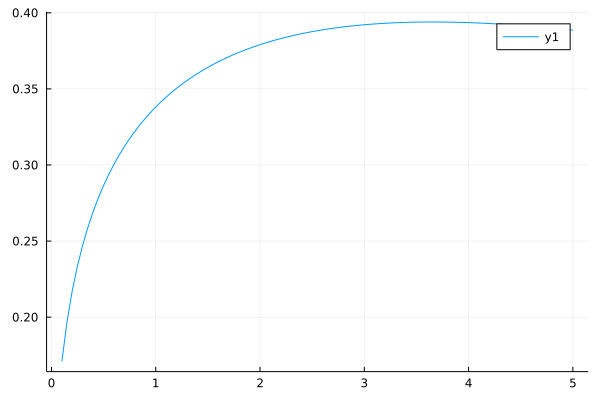

In [33]:
φ = res.solution

using Plots
using NoLib: iti

xvec = [e[1] for e in model.grid[2,:]]
yvec = [e[1] for e in φ[2,:]]

plot(xvec, yvec)

# improve the plot....


## Rewriting time_iteration


### Check SGrid, CGrid, PGrid objects


In [ ]:
using NoLib: SGrid, CGrid, PGrid, ×

### Check GArray object


In [50]:
### GArray objects represent a vector of points, matching the geometry of the grid
### Create constant initial guess
using NoLib: GArray
x0 = GArray(
    model.grid,
    [SVector(0.1) for s in  model.grid[:]]
)

GArray{PGrid{SGrid{1}, CGrid{1}, 2}, SVector{1, Float64}}(PGrid{SGrid{1}, CGrid{1}, 2}(SGrid{1}(SVector{1, Float64}[[-0.1], [0.1]]), CGrid{1}(((0.1, 5.0, 100),)), SVector{2, Float64}[[-0.1, 0.1], [0.1, 0.1], [-0.1, 0.1494949494949495], [0.1, 0.1494949494949495], [-0.1, 0.198989898989899], [0.1, 0.198989898989899], [-0.1, 0.24848484848484848], [0.1, 0.24848484848484848], [-0.1, 0.29797979797979796], [0.1, 0.29797979797979796]  …  [-0.1, 4.802020202020202], [0.1, 4.802020202020202], [-0.1, 4.851515151515152], [0.1, 4.851515151515152], [-0.1, 4.901010101010101], [0.1, 4.901010101010101], [-0.1, 4.9505050505050505], [0.1, 4.9505050505050505], [-0.1, 5.0], [0.1, 5.0]]), SVector{1, Float64}[[0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1]  …  [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1]])

### Compare On-grid and off-grid indexing (cf interp.jl)

In [56]:
x0(1,SVector(2.5))

1-element SVector{1, Float64} with indices SOneTo(1):
 0.1

### Check the transition iterator $\tau$


In [61]:
ss = [NL.iti(model.grid)...][10]
xx = x0[10]

1-element SVector{1, Float64} with indices SOneTo(1):
 0.1

In [65]:
[NL.τ(model, ss, xx)...]

2-element Vector{Tuple{Float64, Tuple{Tuple{Int64}, Tuple{SVector{1, Float64}, SVector{1, Float64}}}}}:
 (0.1, ((1,), ([-0.1], [0.36818181818181817])))
 (0.9, ((2,), ([0.1], [0.36818181818181817])))

### Write the optimality function `F(model, s, x, x0::GArray)` where s is a grid point, x a controls and  x0 a vector of controls


In [75]:
function F_(model, s, x, φ)
    sum(w*arbitrage(model, s, x, S, φ(S)) for (w, S) in NL.τ(model, s, x))
end

F_ (generic function with 1 method)

In [76]:
F_(model, ss, xx, x0)

1-element SVector{1, Float64} with indices SOneTo(1):
 0.36176569493143174

### Vectorize the optimality function `F(model, x1, x0)`


In [85]:
function F_(model, x, φ)
    GArray(
        model.grid,
        [F_(model, s, x, φ) for (s,x) in zip(NL.iti(model.grid), (x))]
    )

end

F_ (generic function with 2 methods)

In [86]:
F_(model, x0, x0)

GArray{PGrid{SGrid{1}, CGrid{1}, 2}, SVector{1, Float64}}(PGrid{SGrid{1}, CGrid{1}, 2}(SGrid{1}(SVector{1, Float64}[[-0.1], [0.1]]), CGrid{1}(((0.1, 5.0, 100),)), SVector{2, Float64}[[-0.1, 0.1], [0.1, 0.1], [-0.1, 0.1494949494949495], [0.1, 0.1494949494949495], [-0.1, 0.198989898989899], [0.1, 0.198989898989899], [-0.1, 0.24848484848484848], [0.1, 0.24848484848484848], [-0.1, 0.29797979797979796], [0.1, 0.29797979797979796]  …  [-0.1, 4.802020202020202], [0.1, 4.802020202020202], [-0.1, 4.851515151515152], [0.1, 4.851515151515152], [-0.1, 4.901010101010101], [0.1, 4.901010101010101], [-0.1, 4.9505050505050505], [0.1, 4.9505050505050505], [-0.1, 5.0], [0.1, 5.0]]), SVector{1, Float64}[[0.015534230369211845], [0.24115324715065123], [0.10157442959569879], [0.3261104939871584], [0.13786290828297898], [0.3564443889295624], [0.15262214549231712], [0.3642056014526868], [0.15706226011257926], [0.36176569493143174]  …  [-0.025364238864472644], [0.08064759091467609], [-0.025890212684111083], [0

### Given x1, compute the derivative w.r.t. x0. Solve for the optimal x1 given x0.


In [89]:
using ForwardDiff

In [90]:
function dF_1_(model, s, x, φ)
    ForwardDiff.jacobian(
        u->F_(model, s, u, φ),
        x
    )
end

dF_1_ (generic function with 1 method)

In [91]:
dF_1_(model, ss, xx, x0)

1×1 SMatrix{1, 1, Float64, 1} with indices SOneTo(1)×SOneTo(1):
 -7.69762853460251

In [92]:
function dF_1_(model, x, φ)
    GArray(
        model.grid,
        [dF_1_(model, s, x, φ) for (s,x) in zip(NL.iti(model.grid), (x))]
    )

end

dF_1_ (generic function with 2 methods)

In [94]:
J = dF_1_(model, x0, x0)

GArray{PGrid{SGrid{1}, CGrid{1}, 2}, SMatrix{1, 1, Float64, 1}}(PGrid{SGrid{1}, CGrid{1}, 2}(SGrid{1}(SVector{1, Float64}[[-0.1], [0.1]]), CGrid{1}(((0.1, 5.0, 100),)), SVector{2, Float64}[[-0.1, 0.1], [0.1, 0.1], [-0.1, 0.1494949494949495], [0.1, 0.1494949494949495], [-0.1, 0.198989898989899], [0.1, 0.198989898989899], [-0.1, 0.24848484848484848], [0.1, 0.24848484848484848], [-0.1, 0.29797979797979796], [0.1, 0.29797979797979796]  …  [-0.1, 4.802020202020202], [0.1, 4.802020202020202], [-0.1, 4.851515151515152], [0.1, 4.851515151515152], [-0.1, 4.901010101010101], [0.1, 4.901010101010101], [-0.1, 4.9505050505050505], [0.1, 4.9505050505050505], [-0.1, 5.0], [0.1, 5.0]]), SMatrix{1, 1, Float64, 1}[[-11.505079766816605;;], [-12.541444199904817;;], [-10.246789546695585;;], [-10.984590477096688;;], [-9.10780073051009;;], [-9.637097483458232;;], [-8.17570134966522;;], [-8.557854637942466;;], [-7.422112631193248;;], [-7.69762853460251;;]  …  [-1.6024692855073117;;], [-1.4697521814281156;;], 

In [ ]:
Let's find x such that F_(model, x, x0)

In [103]:
x1 = x0
for i=1:5
    r = F_(model, x1, x0)
    ϵ = NL.norm(r)
    println(ϵ)
    if ϵ<1e-8
        break
    end
    J =  dF_1_(model, x1, x0)
    # [J.data[i]\ r.data[i] for i=1:length(r)]
    dx = GArray(
        model.grid,
        - J.data .\ r.data
    )
    x1 = x1 + dx
end

0.3642056014526868
0.049052527188173545
0.001205932750322436
7.90117985587091e-7
3.4031805151713e-13


### Compute the derivative w.r.t. x1. Make an improvement step.


### Write a time iteration method with an improvement option.
